In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

### *A) Importar Dados de Chuvas, Pressao, Precipitação e Temperatura*

In [50]:
# Carga do arquivo csv preparada para a análise exploratória de dados. Ajustes de separador, primeira coluna como índice e parse de Data.
datapath =  '../../Data/process/patio1_posicaoVento.parquet'
df_patio = pd.read_parquet(datapath)

In [3]:
df_patio.head(3)

,Longitude,Latitude,Magnitude_Observada,Direcao,Data,Valor_Pressao,Valor_Temp,Valor_Chuva,Magnitude_Verif,PosicaoVento
0,-42.75,-14.25,6.82,97.36,2017-01-01 00:00:00,1013.14,25.93,0.0,9.82,E
1,-42.75,-14.25,6.91,94.65,2017-01-01 01:00:00,1013.34,25.73,0.0,8.74,E
2,-42.75,-14.25,7.27,92.98,2017-01-01 02:00:00,1013.04,25.50,0.0,8.45,E


### <span style="color:#4169E1">**B1. Grafico de Dispersão em 30 DIAS de dados**

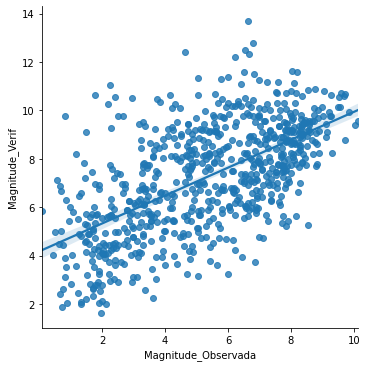

In [4]:
# LINEAR 
df_patio_grafico = df_patio.loc[1:732]
sns.lmplot(data=df_patio_grafico, y = "Magnitude_Verif", x = "Magnitude_Observada")

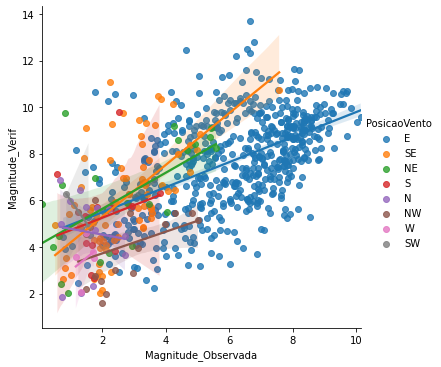

In [6]:
# LINEAR 
df_patio_grafico = df_patio.loc[1:732] # 30 dias
sns.lmplot(data=df_patio_grafico, y = "Magnitude_Verif", x = "Magnitude_Observada",hue='PosicaoVento')

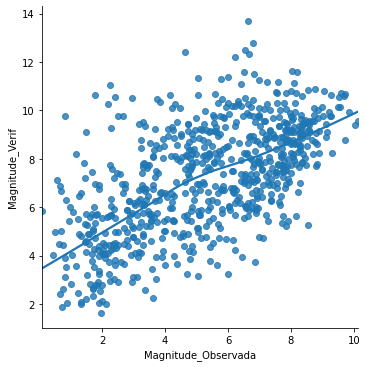

In [7]:
# NAO LINEAR
df_patio_grafico = df_patio.loc[1:732]
sns.lmplot(data=df_patio_grafico, y = "Magnitude_Verif", x = "Magnitude_Observada",lowess = True)

## Normalizar Dados
df_patio['Magnitude_Verif'] = (df_patio['Magnitude_Verif']/df_patio['Magnitude_Verif'].iloc[0]*10)
df_patio['Magnitude_Observada'] = (df_patio['Magnitude_Observada']/df_patio['Magnitude_Observada'].iloc[0]*10)
df_patio['Valor_Pressao'] = (df_patio['Valor_Pressao']/df_patio['Valor_Pressao'].iloc[0]*10)
df_patio['Valor_Temp'] = (df_patio['Valor_Temp']/df_patio['Valor_Temp'].iloc[0]*10)
df_patio['Valor_Chuva'] = (df_patio['Valor_Chuva']/df_patio['Valor_Chuva'].iloc[0]*10)
df_patio.head(5)

### <span style="color:Blue"> ***B) Regressão Linear*** 

### <span style="color:#4169E1">**B1. Cálculos**

- slope = Inclinação da linha de regressão.<br>
- intercept= Interceptação da linha de regressão.<br>
- rvalue = Coeficiente de correlação.<br>
- pvalue= Valor p bilateral para um teste de hipótese cuja hipótese nula é que a inclinação é zero, usando o Teste de Wald com distribuição t da estatística de teste<br>
- stderr = (Desvio)Erro padrão da inclinação estimada (gradiente), considerando a normalidade residual.<br>

In [53]:
x = df_patio['Magnitude_Observada'] 
y = df_patio['Magnitude_Verif']
a, b, r, p, std_err = stats.linregress(x,y)

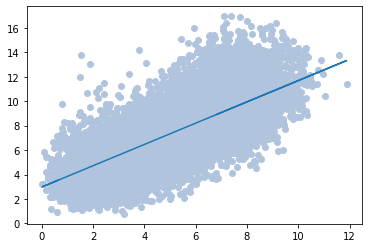

In [54]:
def estimate_y(x):
    return a * x + b

df_patio['y_Magnitude_Verif'] = df_patio['Magnitude_Observada'].apply(estimate_y)  
# A partir da coluna Vento observado, será criado uma nova coluna chamada y_estimado

plt.figure()
plt.plot(df_patio['Magnitude_Observada'], df_patio['y_Magnitude_Verif'])
plt.scatter(df_patio['Magnitude_Observada'], df_patio['Magnitude_Verif'], color='#B0C4DE')
plt.show()

### <span style="color:#4169E1">**B2. Coeficiente de Determinação**

In [55]:
coef_determinacao = r**2

print("A correlação é de: " + str(coef_determinacao) + " %") # Proximo de 1 é uma boa estimativa

A correlação é de: 0.4633678279690343 %


### <span style="color:#8B008B"> ***C) Regressão Linear Multipla*** 

<b>Formula:</b><br>
<i>
VentoVerificado = b0 + (b1 x VentoObservado) + (b2 x PressaoAtmosferica) + (b3 x Temperatura) + (b4 x Chuva) + (b5 x DirecaoGraus) + (b6 x DirecaoCardeal)
</i>
<p>
<b>Avaliação do P-valor:</b>
<br>p-valor = Probabilidade dos valores se referirem à hipotese nula
<br>p-valor baixo -> Melhor associação entre o preditor e o valor

<p><b>Tabela:</b>
<br>p-valor < 0.001 -> Alto nivel de certeza
<br>p-valor < 0.05  -> Nível de certeza moderado
<br>p-valor < 0.01  -> Nível de certeza fraco
<br>p-valor > 0.1  -> Não há nivel de certezaaceitávelno resultado

<i>Ou seja,</i> Coluna P>|t|. Quanto mais próximo o valor for de zero(0), mais correlacionado a variavel é.
<p>
<b>Como Avaliar o Summary:</b><br>
    1. <b><i>Teste F de Significancia  Global</b></i> (O modelo é útil para prever ?)<br>
Resposta: Verifique se o valor da coluna 'Prob(F-statistic) = valor p do teste F' é < 0,05. 
<br>Se houver, significa pelo menos 1 variavel no modelo está correlacionada a variavel dependente
<p>
    2. <b><i>Teste de significancia individua</b></i><br>
Resposta: Na tabela, verifique o valor P>|y| das variaveis independente são menores que 0.05.
<br>Se houver, há evidencias estatisticas de relação.
<p>
    3.<b><i>R2 e R2-Ajustado.</b></i><br>
Resposta: As variaveis independente explicam qual % de variabilidade da variavel dependente.<br>
    Verifique o valor da variavel "R-squared" para responder. Já o R2-Ajustado,que é sempre um pouco menor que o R2
    deve ser usado quando queremos comparar modelos com diferentes quantidades de variaveis.
<p>
<b><i>Quais são os coeficientes da equação</b></i><br>
Resposta: y = coef.intercept + coef.direcao x {valorDirecao} + coef.Magnitude_Observada x {Magnitude_Observada} + ...

#### <span style="color:#8B008B"> **R2 = 0.463 ~ Usando (Vento Previsto + Direção)**

In [73]:
# Método: Ordinary Least Square
# Estimador escolhido: R2
#
model = ols('Magnitude_Verif ~  Magnitude_Observada + Direcao ', data = df_patio) #
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     3781.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:28:52   Log-Likelihood:                -18680.
No. Observations:                8760   AIC:                         3.737e+04
Df Residuals:                    8757   BIC:                         3.739e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.9873      0.091     32.675      0.000       2.808       3.167
Magnitude_Observada     0.8700      0.010     84.159      0.000       0.850       0.890
Direcao             -8.258e-05      0.000     -0.167      0.867      -0.001       0.001
==============================================================================
Omnibus:                      152.899   Durbin-Watson:                   0.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              160.765
Skew:                           0.331   Prob(JB):                     1.23e-35
Kurtosis:                       2.969   Cond. No.                         487.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### <span style="color:#8B008B"> **R2 = 0.469 ~  Usando (Vento Previsto + Direção + Pressão Atmosferica)**

In [68]:
model = ols('Magnitude_Verif ~ Magnitude_Observada + Direcao + Valor_Pressao', data = df_patio) #
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     2578.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:50:29   Log-Likelihood:                -18634.
No. Observations:                8760   AIC:                         3.728e+04
Df Residuals:                    8756   BIC:                         3.730e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -65.7600      7.127     -9.227      0.000     -79.730     -51.790
Magnitude_Observada     0.8034      0.012     64.876      0.000       0.779       0.828
Direcao              8.798e-06      0.000      0.018      0.986      -0.001       0.001
Valor_Pressao           0.0681      0.007      9.647      0.000       0.054       0.082
==============================================================================
Omnibus:                      141.602   Durbin-Watson:                   0.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.149
Skew:                           0.317   Prob(JB):                     6.76e-33
Kurtosis:                       2.934   Cond. No.                     3.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style="color:#8B008B"> **R2 = 0.472 ~  Usando (Vento Previsto + Direção + Temperatura)**

In [67]:
model = ols('Magnitude_Verif ~ Magnitude_Observada + Direcao + Valor_Temp', data = df_patio) #
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     2612.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:50:27   Log-Likelihood:                -18607.
No. Observations:                8760   AIC:                         3.722e+04
Df Residuals:                    8756   BIC:                         3.725e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8102      0.201      4.040      0.000       0.417       1.203
Magnitude_Observada     0.9444      0.012     79.107      0.000       0.921       0.968
Direcao                 0.0002      0.000      0.322      0.748      -0.001       0.001
Valor_Temp              0.0691      0.006     12.170      0.000       0.058       0.080
==============================================================================
Omnibus:                      226.157   Durbin-Watson:                   0.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.490
Skew:                           0.401   Prob(JB):                     1.34e-53
Kurtosis:                       3.158   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style="color:#8B008B"> **R2 = 0.487 ~  Usando (Vento Previsto + Direção + Pressão Atmosferica + Temperatura)**

In [69]:
# Método: Ordinary Least Square
# Estimador escolhido: R2
#
model = ols('Magnitude_Verif ~ Magnitude_Observada + Direcao + Valor_Temp + Valor_Pressao', data = df_patio) #
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     2079.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:50:40   Log-Likelihood:                -18482.
No. Observations:                8760   AIC:                         3.697e+04
Df Residuals:                    8755   BIC:                         3.701e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -121.4188      7.687    -15.795      0.000    -136.487    -106.350
Magnitude_Observada     0.8680      0.013     68.271      0.000       0.843       0.893
Direcao                 0.0005      0.000      0.931      0.352      -0.000       0.001
Valor_Temp              0.1070      0.006     17.579      0.000       0.095       0.119
Valor_Pressao           0.1199      0.008     15.906      0.000       0.105       0.135
==============================================================================
Omnibus:                      219.537   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.034
Skew:                           0.392   Prob(JB):                     5.57e-52
Kurtosis:                       3.175   Cond. No.                     3.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### <span style="color:#8B008B"> **R2 = 0.487 ~ Usando (Vento Previsto + Direção + Pressão Atmosferica + Temperatura + Chuva)**
Chuva não contribui para a correlação...

In [71]:
# Método: Ordinary Least Square
# Estimador escolhido: R2
#
model = ols('Magnitude_Verif ~ Magnitude_Observada + Direcao + Valor_Pressao + Valor_Temp + Valor_Chuva', data = df_patio) #
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Magnitude_Verif   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     1663.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        14:51:05   Log-Likelihood:                -18481.
No. Observations:                8760   AIC:                         3.697e+04
Df Residuals:                    8754   BIC:                         3.702e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -122.6150      7.744    -15.834      0.000    -137.794    -107.436
Magnitude_Observada     0.8698      0.013     67.981      0.000       0.845       0.895
Direcao                 0.0004      0.000      0.813      0.417      -0.001       0.001
Valor_Pressao           0.1210      0.008     15.946      0.000       0.106       0.136
Valor_Temp              0.1082      0.006     17.559      0.000       0.096       0.120
Valor_Chuva             0.1028      0.080      1.278      0.201      -0.055       0.261
==============================================================================
Omnibus:                      218.638   Durbin-Watson:                   0.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.002
Skew:                           0.392   Prob(JB):                     9.33e-52
Kurtosis:                       3.175   Cond. No.                     3.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""